# Motorcycle data set analysis and category prediction
Using this data set, we could try to build a model or models that capture the essence of what has
historically been offered under each category and thus, be able to tell what type a bike belongs to, according
to its technical specifications.

## 1. Data Exploration and preparation
The data set with the bikes’ information has been downloaded from Kaggle ([Motorcycle Specifications
Dataset](https://www.kaggle.com/datasets/emmanuelfwerr/motorcycle-technical-specifications-19702022)). We will be using the "cleaned" version of the data set, instead of the "raw" one. This dataset contains 38472 observations of different motorcycle models, described by 28 attributes
in an available preprocessed version of the dataset. The data in this dataset was originally scraped
form [Bikez.com](https://bikez.com/main/index.php). However, these data still need some preprocessing in order to be valid for machine learning
models to learn from its information.

We start by importing helpful functions that we have defined ourselves in four associated modules and setting up the paths to the folders that we will be using:

In [1]:
# Import user-defined functions to work with the data, create plots, and apply different machine learning methods.
# These functions are defined in seperate modules to preserve the readability of the process in the notebook.

from plot_funcs import *
from funcs import *
from apply_ml import *
import specific_funcs

# Paths to the folders:
import os

PROJECT_PATH = os.getcwd() # Main folder of the project, where the notebook and modules are located
DATA_PATH = os.path.join(PROJECT_PATH, 'data') # Contains the data files
RESULTS_PATH = os.path.join(PROJECT_PATH, 'results') # Location of any output produced (plots, models)

### 1.1. Data cleaning
The first step is, of course, to load the data. I will be using pandas to work on the data set.

The data set has a lot of columns, which come in very different formats and data types. I will first identify the features that are provided as a numerical value and force their data type to be numpy.float64 and numpy.int32.

In [2]:
# Load data from the curated data set
df = pd.read_csv(DATA_PATH+r'\all_bikez_curated.csv')

# Ensure numerical data type columns
type_float = ['Rating', 'Displacement (ccm)', 'Power (hp)', 'Torque (Nm)',
              'Bore (mm)', 'Stroke (mm)', 'Fuel capacity (lts)',
              'Dry weight (kg)', 'Wheelbase (mm)', 'Seat height (mm)']
type_int = ['Year']
datatypes = {k:np.float64 for k in type_float}
for k in type_int:
    datatypes[k] = np.int32

df = df.astype(datatypes) 

We will start by dropping the rows where the motorcycle category is not specified (the value is "Unspecified category"), since that is the label of the classification problem. Then, since we need enough examples to characterize each category, we also drop those rows belonging to an underrepresented category. I've arbitrarily set the "underrepresentation" threshold to be 200.

In [3]:
# Drop rows with unspecified category
unsp_ind = df['Category'] == 'Unspecified category'
df = df[~unsp_ind]
# Drop rows of underepresented categories
count_threshold = 200
counted = df.groupby('Category').count()
cat_to_drop = counted[counted.max(axis=1) < count_threshold].index.tolist()
index_to_drop = []
for cat in cat_to_drop:
    index_to_drop += df[df['Category'] == cat].index.tolist()
df = df.drop(index=index_to_drop)

At this point, he count of examples of each category remaining  is displayed on a bar plot (the name of some categories is shortened to obtain a more compact plot). We can see that the data set is quite imblanced.

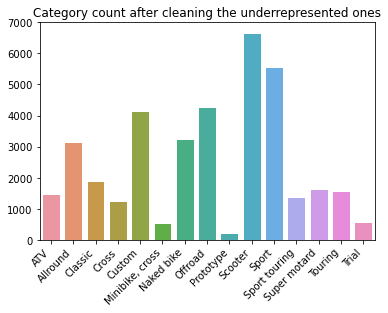

In [4]:
# Shorten category name for ease of plotting
df = change_categories_names(df, {'Prototype / concept model':'Prototype','Custom / cruiser':'Custom',\
                   'Cross / motocross':'Cross', 'Enduro / offroad':'Offroad'})

fig, ax = bars_categories_count(df, 'Category', title='Category count after cleaning the underrepresented ones')

### Balancing the data

For this reason, we need to make a selection of data to get a more balanced set.
First, let's select only the rows that contain all the information (values in all rows). Before that, we will drop the columns that are not useful for the classification task. One could argue that the "Brand" and "Model" columns could be used, but the goal is to classify the bikes from technical specifications only.

In the remaining rows, some categories have now too few examples. We set again a threshold and drop the categories that don't have enough examples. In this case, I've chosen 150 examples as threshold.
In order for the resulting data set to be balanced, the categories that are overrepresented are randomly downsamples. The chosen criteria is that no category will have more than double the number of examples that the least frequent category has (i.e: if the least frequent category appears 150 times, categories with more than 300 entries get randomly downsampled to 300 random examples).

In [5]:
# Clean useless columns
irrelevant_columns = ['Brand', 'Model', 'Rating', 'Color options']
dfc = df.drop(columns=irrelevant_columns)

# Select rows that contain all information (for both dfc and dfc_red)
conditions = [~dfc[col].isnull() for col in dfc.columns]
cond = conditions[0]
for c in conditions[1:]:
    cond = cond & c 
selected_rows = cond[cond==True]
df_sel = dfc.loc[selected_rows.index,:]

# Create a reduced data set from the complete rows that is more balanced
## a. Drop rows of underrepresented categories
count_threshold = 150
counted = df_sel.groupby('Category').count()
cat_to_drop = counted[counted.max(axis=1) < count_threshold].index.tolist()
index_to_drop = []
for cat in cat_to_drop:
    index_to_drop += df_sel[df_sel['Category'] == cat].index.tolist()
df_sel_filtered = df_sel.drop(index=index_to_drop)

## b. Random balanced selection
lowest_count = df_sel_filtered.groupby('Category').count().max(axis=1).min()
n_random_rows = lowest_count * 2
row_blocks = []
for cat in df_sel_filtered.groupby('Category').count().index:
    row_blocks.append(random_rows(df_sel_filtered[df_sel_filtered['Category']==cat], n_random_rows))
dfc_red_sel = pd.concat(row_blocks)
dfc_red_sel.sort_index(inplace=True)

The resulting data set has the number of samples of each category shown in the following bar chart:

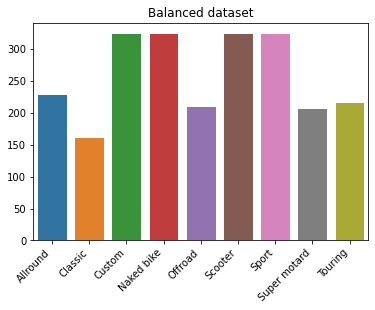

In [6]:
fig, ax = bars_categories_count(dfc_red_sel, 'Category', title='Balanced dataset')

Now is a good moment to define some variables that can be helpful for the remaining work:

In [7]:
data_labels = dfc_red_sel['Category'] # pandas Series of the data labels (to be used as ground truth in classification)
unique_labels = data_labels.unique() # numpy array containing the unique categories in the data set

num_labels_dict = {k:v for (k,v) in zip(range(len(unique_labels)), unique_labels)} # Keys are numbers, values are labels
labels_num_dict = {v:k for (k,v) in num_labels_dict.items()} # Keys are labels, values are the corresponding numbers
numeric_labels = data_labels.apply(lambda x: labels_num_dict[x]) # Identify each label with a number
binary_labels, names = binarize_categorical(data_labels) # binary_labels is a matrix of size n_rows*n_categories representing a one-hot encoding of the labels


### Preprocessing the features
Then, we will identify and separate the columns having numerical values from the rest, which I will call "categorical" (we will not necessarily use all of them as purely categorical data, as we will see later). Categorical columns need a heavy preprocessing in order to obtain useful information from them, whereas numerical columns only need scaling and minor adjustments.

In [8]:
# List columns as numerical or categorical
features_num = ['Year', 'Displacement (ccm)', 'Power (hp)', 'Torque (Nm)',
              'Bore (mm)', 'Stroke (mm)', 'Fuel capacity (lts)',
              'Dry weight (kg)', 'Wheelbase (mm)', 'Seat height (mm)']
features_cat = [feat for feat in dfc.columns if feat not in features_num and feat != 'Category']

In [9]:
df_cat = dfc_red_sel[features_cat]
df_num = dfc_red_sel[features_num]

Let's start with the scaling of numeric columns:

In [10]:
# Since all entries are from 1968 onwards, the difference in years would be barely noticeable for the machine learning models
# (the effective range is just 54 years on a scale of magnitude 10^3)
df_num = rescale_years(df_num, col='Year', timerange=100)

# Scale all numerical features to have mean 0 and standard deviation 1:
from sklearn.preprocessing import StandardScaler
df_num_feat = df_num.copy()
df_num_feat.loc[:,:] = StandardScaler().fit(df_num).transform(df_num)

F:\Documentos\Data_Science\Master\Georgia_Tech-MSc_Analytics\Courses\OMSA6740_Computational_Data_Analysis-Machine_Learning1\PROJECT\ISYE6740_project\funcs.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,col] = df.loc[:,col] - subtract


As we can see in the heatmap below, representing the correlation coefficient between the numerical features, many of them are strongly correlated to the rest. Year and Seat height seem to be he only ones not correlated to any of the others. On the other hand, Displacement, Torque and Dry weight are strongly related to most of the other features, which means that they are not adding much information.

Text(0.5, 1.0, 'Correlation matrix')

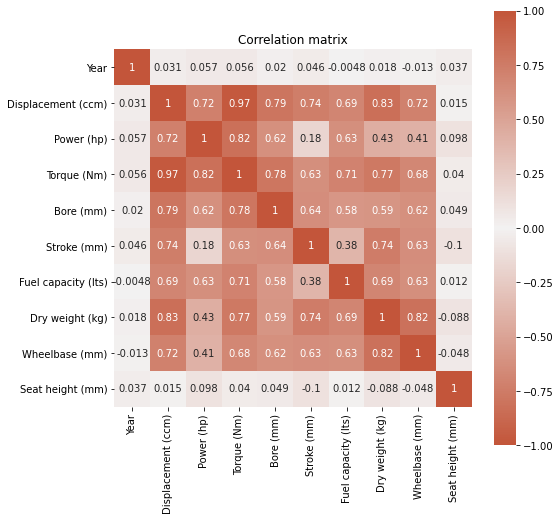

In [11]:
#df_num_scaled = pd.DataFrame(num_scaled, index=df_num.index, columns=df_num.columns)
corr_mat = df_num_feat.corr()

my_cmap = sns.diverging_palette(20, 20, as_cmap=True)
fig, ax = plt.subplots(figsize=(8,8))
heatmap = sns.heatmap(corr_mat, vmin=-1, vmax=1, annot=True, square=True, cmap=my_cmap, ax=ax)
heatmap.set_title('Correlation matrix')

#### Preprocessing the categorical / text features

We will be able to extract a lot of information from the columns that don't have simple numerical values. Following, each of them is individually analized and valuable new features are obtained from them.
This whole preprocessing can be a little bit boring and, on top of that, all of it is actually performed by functions defined in the accompanying modules, so the actual magic is not shown in the notebook cells.

In [12]:
column_names = ""
for name in df_cat.columns:
    column_names += name + ", "
column_names = column_names.strip(', ')
print('Columns to preprocess: ', column_names)

Columns to preprocess:  Engine cylinder, Engine stroke, Gearbox, Fuel system, Fuel control, Cooling system, Transmission type, Front brakes, Rear brakes, Front tire, Rear tire, Front suspension, Rear suspension


#####  Engine cylinders
The number of cylinders can be deduced from the string description in the corresponding column. Since there are not many unique values (descriptions) in this column, the easiest is to map each of them to the corresponding number (done by the function n_cylinders):

*Note: at this point I don't know why I am still getting the SettingWithCopyWarning. I will just ignore it.

In [13]:
df_cat.columns

Index(['Engine cylinder', 'Engine stroke', 'Gearbox', 'Fuel system',
       'Fuel control', 'Cooling system', 'Transmission type', 'Front brakes',
       'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension',
       'Rear suspension'],
      dtype='object')

In [14]:
temporary_columns = [] # This list will hold the names of columns that will not be useful after the preprocessing, which will be removed

# Engine cylinders to numeric
df_cat['n_cylinders'] = df_cat.loc[:,'Engine cylinder'].apply(n_cylinders)
temporary_columns.append('Engine cylinder')

sorted(df_cat['n_cylinders'].unique())

C:\Users\remns\AppData\Local\Temp/ipykernel_14952/1012838276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat['n_cylinders'] = df_cat.loc[:,'Engine cylinder'].apply(n_cylinders)


[1, 2, 3, 4, 6]

##### Engine stroke
This can be converted to a binary feature (strokes can be 2 or 4). The feature will have value 1 if it is a four stroke engine and value 0 if it is a two stroke engine. For some reason, while working on this project I forgot about the existance of [sklearn's LabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html), so I just wrote my own binarization functions.

In [15]:
# Binarization of the Engine stroke feature
for col_name in df_cat['Engine stroke'].unique():
    if 'four' in col_name and 'stroke' in col_name:
        fourstroke_name = col_name
df_cat.loc[:,'Engine stroke'] = df_cat.loc[:,'Engine stroke'].replace({'Diesel':fourstroke_name})
df_cat = feature_to_binary(df_cat, 'Engine stroke')

C:\Users\remns\AppData\Local\Temp/ipykernel_14952/2385019920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat.loc[:,'Engine stroke'] = df_cat.loc[:,'Engine stroke'].replace({'Diesel':fourstroke_name})
F:\Documentos\Data_Science\Master\Georgia_Tech-MSc_Analytics\Courses\OMSA6740_Computational_Data_Analysis-Machine_Learning1\PROJECT\ISYE6740_project\funcs.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,names[0]] = bin_array.T


In [16]:
df_cat.iloc[:,-2:].head()

,n_cylinders,Engine stroke_ four-stroke
170,1,1.0
171,1,1.0
226,1,1.0
227,1,1.0
332,1,1.0


##### Fuel system
This is a quite complex feature. Each entry is a textual description, where even though some of them are identical, there are 408 unique descriptions. The descriptions include numeric values indicating the dimensions of parts (often a diameter), brand names, common conjuctions and prepositions... We need a way to extract useful and concise information from these descriptions.
In order to do this, we can form clusters, where similar descriptions are grouped together. We will do that using the K-Means algorithm ([scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)). Then, we can one-hot encode the examples of our data set according to the cluster they belong to.

In [18]:
unique_categories = df_cat['Fuel system'].unique()
len(unique_categories)

411

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

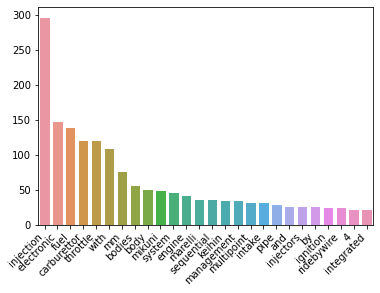

In [19]:
# Count the number of times each word appears in all entries of 'Fuel system' and keep only those that appear more than 20 times
sorted_words = find_main_words(df_cat['Fuel system'])
sorted_frequent_words = sorted_words[sorted_words>20]

# Visualize the frequency of the words found
bar_plot_series(sorted_frequent_words)

Here we can see many words that are either not informative about technical details, or which are difficult to interpret without the context of the whole sentence. We will remove those from the selection of words

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

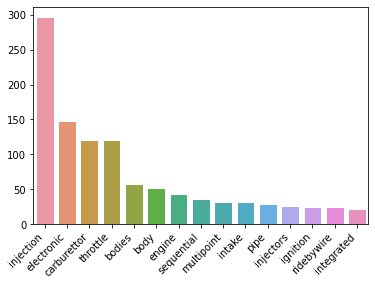

In [20]:
discard_words = ['with','mm','mikuni','system','keihin','marelli','management',
                 'and','by','x','4', 'fuel']
sorted_few_words = sorted_frequent_words[[i for i in sorted_frequent_words.index if i not in discard_words]]
bar_plot_series(sorted_few_words)

At this point, it is interesting to mention that, for anyone possessing basic notions on engines, it is clear that we should be able to identify at least two clearly differentiated groups: sentences including the word "injection" vs sentences including the word "carburettor", since those are two completely different systems. Your engine will have either one or the other.

Now, using the function find_feature_categories() (user-defined under funcs.py), we can obtain clusters of sentences.

1- This function first forms a matrix of binary sentence embeddings. This means that each sentence is a vector of length equal to the number of unique words shown in the bar plot above. If a word appears in the sentence, its corresponding position in the vector has value 1. If the word is not in the sentence, that position has a 0.

2- Then, that matrix of sentence embeddings is used as input for the K-Means algorithm to group them. After trying with several number of clusters, I sticked to forming only two. Wen forming three or more clusters, the new clusters formed did't seem really representative of real similar fuel systems.

*Note: actually, before performing K-Means, the sentences matrix is being reduced using PCA, I initially included this step to be able to visualize the results of K-Means, but I kept it because, interestingly, it doesn't undermine the quality of the clusters formed.

In [21]:
clusters, cluster_word_counter, clusters_sentences =\
    find_feature_categories(df_cat, 'Fuel system', sorted_few_words, 2)
df_cat, new_column = feature_transform_to_clusters(df_cat, 'Fuel system',
                                                   clusters_sentences)
temporary_columns.append(new_column)
# We obtain a new binary feature, where 1 and 0 represent the different clusters
df_cat = feature_to_binary(df_cat, 'Fuel system_reduced')

E:\Anaconda\envs\uoc\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
F:\Documentos\Data_Science\Master\Georgia_Tech-MSc_Analytics\Courses\OMSA6740_Computational_Data_Analysis-Machine_Learning1\PROJECT\ISYE6740_project\funcs.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_column] = df.loc[:,col_name].apply(lambda x: map_feature_to_cluster(x, clusters_sentences))
F:\Documentos\Data_Science\Master\Georgia_Tech-MSc_Analytics\Courses\OMSA6740_Computational_Data_Analysis-Machine_Learning1\PROJECT\ISYE6740_project\funcs.py:100: S

In [22]:
clusters_df = pd.DataFrame(cluster_word_counter)
clusters_df

,0,1
bodies,57,0
body,51,0
carburettor,4,117
electronic,151,1
engine,43,0
ignition,26,0
injection,293,4
injectors,26,0
intake,39,1
integrated,22,0


##### Fuel control
There are 9 unique Fuel control types in the dataset but, as we see below, 4 of them are stringly underrepresented. We will group all of those under the "Fuel control_Other" category. Here I've set the threshold at 200 occurrences, although one could argue that OHC and OHV categories could be a feature of their own, in which case the threshold could be around 100.

In [24]:
unique_categories = df_cat['Fuel control'].unique()
#Number of unique categories
len(unique_categories)

10

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

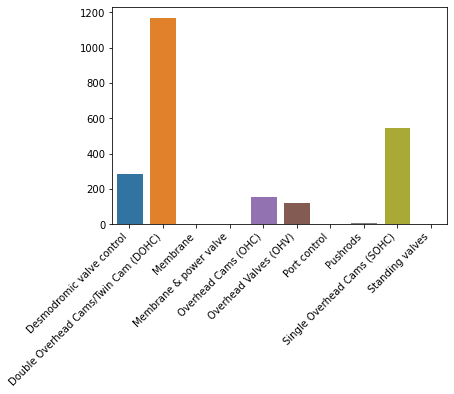

In [25]:
#Count of each category
unique_categories_count = count_unique_categories(df_cat, 'Fuel control')
bar_plot_series(unique_categories_count)

In [26]:
df_cat = feature_to_binary(df_cat, 'Fuel control')
control_cols = [c for c in df_cat.columns if 'Fuel control' in c and c != 'Fuel control']
control_df = df_cat.loc[:, control_cols]
control_cols_sparse = control_df.loc[:,control_df.sum(axis=0)[control_df.sum(axis=0)<200].index.tolist()]
df_cat['Fuel control_Other'] = control_cols_sparse.sum(axis=1)
df_cat.drop(columns=control_cols, inplace=True)

F:\Documentos\Data_Science\Master\Georgia_Tech-MSc_Analytics\Courses\OMSA6740_Computational_Data_Analysis-Machine_Learning1\PROJECT\ISYE6740_project\funcs.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,names[i]] = col_t.T
F:\Documentos\Data_Science\Master\Georgia_Tech-MSc_Analytics\Courses\OMSA6740_Computational_Data_Analysis-Machine_Learning1\PROJECT\ISYE6740_project\funcs.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,names[i]] = col_t.T
F:\Documentos\Data_Science\Master\Geor

##### Cooling system
Here we are facing an wasy case, with three clearly differentiated categories. We will one-hot encode them.

In [27]:
df_cat.columns

Index(['Engine cylinder', 'Engine stroke', 'Gearbox', 'Fuel system',
       'Fuel control', 'Cooling system', 'Transmission type', 'Front brakes',
       'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension',
       'Rear suspension', 'n_cylinders', 'Engine stroke_ four-stroke',
       'Fuel system_reduced', 'Fuel system_reduced_0', 'Fuel control_Other'],
      dtype='object')

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

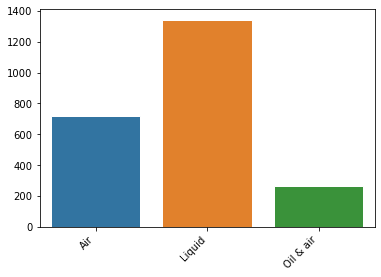

In [28]:
unique_categories = df_cat['Cooling system'].unique()
unique_categories_count = count_unique_categories(df_cat, 'Cooling system')
bar_plot_series(unique_categories_count)


In [29]:
df_cat = feature_to_binary(df_cat, 'Cooling system')

##### Transmission type
Same as before, three clear unique categories.

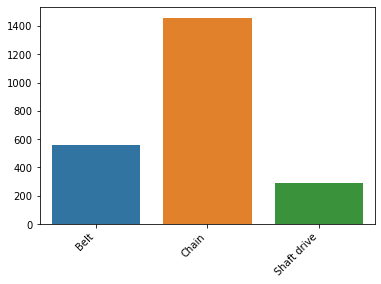

In [30]:
unique_categories = df_cat['Transmission type'].unique()
unique_categories_count = count_unique_categories(df_cat, 'Transmission type')
bar_plot_series(unique_categories_count)
df_cat = feature_to_binary(df_cat, 'Transmission type')

##### Brakes
The descriptions of the braking systems are relatively complex. We can, however, identify key words and obtain relevant features from the description of the system.

To this end, we use the user-defoned function subfeature_from_feature. This function allows to create a new feature  column, where each row will have a numeric value depending on whether a key word is found in the description of its braking system. As an example, we can create the feature "n_disks_front". In this column, we asign the value 1 if the word "single" is found in the front brake description, the value 2 if the word "double" is found, and the value 0 if the word "drum" is found (drum brakes don't have disks).

We have also used the specific function unify_pistons(). Using the power of Regular Expressions pattern matching, it allows to unify the format in which the number of braking pistons is described.

After the processing of each feature, remaining Nan values are filled as seen in the code ('abs'=0, 'n_pistons...'=1).

In [31]:
# Work on the Front brake feature
unique_categories = df_cat['Front brakes'].unique()
unique_categories_count = count_unique_categories(df_cat, 'Front brakes')

df_cat['Front brakes'] = df_cat.loc[:,'Front brakes'].\
                            apply(lambda x: specific_funcs.unify_pistons(x))
df_cat = subfeature_from_feature(df_cat, 'Front brakes',
                                 'n_disks_front', {'drum':0,'single':1,'double':2})
df_cat = subfeature_from_feature(df_cat, 'Front brakes', 'abs',
                                 {'abs':1})
df_cat['abs'] = df_cat['abs'].fillna(value=0)
df_cat = subfeature_from_feature(df_cat, 'n_disks_front', 'has_front_disk',
                                 {'0':0,'1':1,'2':1})
df_cat = subfeature_from_feature(df_cat, 'Front brakes', 'n_pistons_front',
                                 {'1piston':1,'2piston':2,'3piston':3,'4piston':4,
                                  '6piston':6})
df_cat['n_pistons_front'] = df_cat['n_pistons_front'].fillna(value=1)

In [32]:
# Work on the Rear brake feature
unique_categories = df_cat['Rear brakes'].unique()
unique_categories_count = count_unique_categories(df_cat, 'Rear brakes')

df_cat['Rear brakes'] = df_cat.loc[:,'Rear brakes'].\
                            apply(lambda x: specific_funcs.unify_pistons(x))
df_cat = subfeature_from_feature(df_cat, 'Rear brakes',
                                 'n_disks_rear', {'drum':0,'single':1,'double':2})
df_cat = subfeature_from_feature(df_cat, 'Rear brakes', 'absrear',
                                 {'abs':1})
df_cat['absrear'] = df_cat['absrear'].fillna(value=0)
# Unify abs in one column #
df_cat['abs'] = df_cat[['abs', 'absrear']].max(axis=1)
df_cat.drop('absrear', axis=1, inplace=True)

df_cat = subfeature_from_feature(df_cat, 'n_disks_rear', 'has_rear_disk',
                                 {'0':0,'1':1,'2':1})
df_cat = subfeature_from_feature(df_cat, 'Rear brakes', 'n_pistons_rear',
                                 {'1piston':1,'2piston':2,'3piston':3,'4piston':4,
                                  '6piston':6})
df_cat['n_pistons_rear'] = df_cat['n_pistons_rear'].fillna(value=1)

##### Tyres
The tyre information comes in three possible formats: international standard, numeric and alphanumeric. Once again, Regular Expressions are a perfect tool to extract the information once we know how it is encoded by each format. This is achieved using functions from the user-defined module specific_functions.py.

Here are two useful resources to understand tyre labelling: [chapmoto.com](https://www.chapmoto.com/blog/2018/07/20/motorcycle-tires-101-choosing-the-right-motorcycle-tire/), [dunlop.eu](https://www.dunlop.eu/en_gb/motorcycle/safety-and-technology/tires-explained.html).

For both the front and rear tyres, the following features can be obtained: width, height, speed rating, type of construction, diameter, and labelling format. The labelling format is not a technical specification itself, but it could be useful in identifying bikes since, for example, the numeric format is found mostly on dirt bikes and vintage boikes.

The remaining Nan values have been filled according to different criteria (see code below).

In [33]:
# We add the 'Category' column back, because some Nan values are filled depending on the category of the bike

df_cat['Category'] = data_labels

df_cat = specific_funcs.tyres_columns(df_cat, 'Rear tire')
df_cat = specific_funcs.tyres_columns(df_cat, 'Front tire')
# Fill the Nan values based on bike class
# Width
df_cat = specific_funcs.fill_tyre_width(df_cat, 'Rear tire_width')
df_cat = specific_funcs.fill_tyre_width(df_cat, 'Front tire_width')
# Height
df_cat = specific_funcs.fill_tyre_height(df_cat, 'Rear tire_height')
df_cat = specific_funcs.fill_tyre_height(df_cat, 'Front tire_height')
# Speed
col_name = ' tire_speed'
df_cat.loc[:, 'Rear'+col_name] = df_cat.loc[:, 'Rear'+col_name].fillna(value='A')
df_cat.loc[:, 'Front'+col_name] = df_cat.loc[:, 'Front'+col_name].fillna(value='A')

# Construction
col_name = ' tire_construction'
df_cat.loc[:, 'Rear'+col_name] = df_cat.loc[:, 'Rear'+col_name].fillna(value='B')
df_cat.loc[:, 'Front'+col_name] = df_cat.loc[:, 'Front'+col_name].fillna(value='B')

# Diameter
df_cat = specific_funcs.fill_tyre_diameter(df_cat, 'Rear tire_diameter')
df_cat = specific_funcs.fill_tyre_diameter(df_cat, 'Front tire_diameter')

# Speed to numeric
speed_dict = specific_funcs.tyre_speed_and_construction(keys='lower')
avg = sum(speed_dict.values()) / len(speed_dict)
df_cat = subfeature_from_feature(df_cat, 'Rear tire_speed', 'reartyre_speed',
                                 speed_dict)
df_cat.loc[:, 'reartyre_speed'] = df_cat.loc[:, 'reartyre_speed'].fillna(value=avg)
temporary_columns.append('Rear tire_speed')

df_cat = subfeature_from_feature(df_cat, 'Front tire_speed', 'fronttyre_speed',
                                 speed_dict)
df_cat.loc[:, 'fronttyre_speed'] = df_cat.loc[:, 'fronttyre_speed'].fillna(value=avg)
temporary_columns.append('Front tire_speed')

# Construction to binary
df_cat = feature_to_binary(df_cat, 'Rear tire_construction')
df_cat = feature_to_binary(df_cat, 'Front tire_construction')
temporary_columns.append('Rear tire_construction')
temporary_columns.append('Front tire_construction')

# Format to binary
df_cat['Rear tire_label_format'] = df_cat['Rear tire_label_format'].fillna(value='I')
df_cat = feature_to_binary(df_cat, 'Rear tire_label_format')
df_cat['Front tire_label_format'] = df_cat['Front tire_label_format'].fillna(value='I')
df_cat = feature_to_binary(df_cat, 'Front tire_label_format')
temporary_columns.append('Rear tire_label_format')
temporary_columns.append('Front tire_label_format')

##### Suspension
I didn't find an easy and helpful way to extract useful information from the suspension columns, so I will just drop those.

#### Dropping columns that are not useful anymore

In [34]:
# Drop temporary columns and columns_to_binarize
columns_to_binarize = ['Engine stroke', 'Gearbox', 'Fuel system', 'Fuel control',
                       'Cooling system', 'Transmission type', 'Front brakes',
                       'Rear brakes', 'Front tire', 'Rear tire', 'Front suspension',
                       'Rear suspension']
df_cat = df_cat.drop(columns=temporary_columns+columns_to_binarize)

In [35]:
df_cat.columns

Index(['n_cylinders', 'Engine stroke_ four-stroke', 'Fuel system_reduced_0',
       'Fuel control_Other', 'Cooling system_Liquid', 'Cooling system_Air',
       'Cooling system_Oil & air', 'Transmission type_Chain',
       'Transmission type_Belt', 'Transmission type_Shaft drive',
       'n_disks_front', 'abs', 'has_front_disk', 'n_pistons_front',
       'n_disks_rear', 'has_rear_disk', 'n_pistons_rear', 'Category',
       'Rear tire_width', 'Rear tire_height', 'Rear tire_diameter',
       'Front tire_width', 'Front tire_height', 'Front tire_diameter',
       'reartyre_speed', 'fronttyre_speed', 'Rear tire_construction_B',
       'Front tire_construction_B', 'Rear tire_label_format_I',
       'Rear tire_label_format_N', 'Rear tire_label_format_A',
       'Front tire_label_format_I', 'Front tire_label_format_N',
       'Front tire_label_format_A'],
      dtype='object')

In [36]:
# In case there are Nan values remaining, fill them with a simple method: forward filling
for col in df_cat.columns:
    if df_cat[col].isna().sum()>0:
        df_cat[col] = df_cat[col].fillna(method='ffill')

#### Standardizing the non-binary features obtained from the categorical columns
After trying to fit machine learning methods using all features standardized and also keeping binary features un-standardized, the performanced was not significantly better in any of the two cases. I haven't dug deeper in this question, but for now I will show here the version with non-standardized binary features.

In [38]:
#df_cat_feat = df_cat.loc[:,[c for c in df_cat.columns if c!='Category']]
#cols_tostandard = df_cat_feat.max(axis=0)[df_cat_feat.max(axis=0)>1].index.tolist()
#df_tostandard = df_cat.loc[:,cols_tostandard]
#df_catstandard = StandardScaler().fit(df_tostandard).transform(df_tostandard)
#df_cat[cols_tostandard] = df_catstandard
#df_cat_feat = df_cat.loc[:,[c for c in df_cat.columns if c!='Category']]

In [41]:
#Alternative: standardize all:
df_cat_feat = df_cat.loc[:,[c for c in df_cat.columns if c!='Category']]
df_cat_std = StandardScaler().fit(df_cat_feat).transform(df_cat_feat)
df_cat_feat.loc[:,:] = df_cat_std
df_cat_feat.sort_index(inplace=True)
df_feats = pd.concat([df_num_feat, df_cat_feat], axis = 1)

### Final data set
Now all data is already preprocessed. We can join all columns in one single DataFrame (numeric columns and columns obtained from categorical features).

In [42]:
df_num_feat = df_num.copy()
df_cat_feat.sort_index(inplace=True)
df_num_feat.sort_index(inplace=True)

df_feats = pd.concat([df_num_feat, df_cat_feat], axis = 1)

## 1.2. Data Visualization
We are now left with a data set describing each sample through 45 features. In order to have an intuitive idea of the distribution of the data and similarities/differences between the bikes categories, we can try to visualize them.

Since the data is now 43-dimensional, we need to reduce it to a visualizable feature space (ideally 2D or 3D). We will explore two techniques to project the data on a dimensionally-reduced space, whike keeping its properties as best as possible: Principal Components Analysis and Isomap. We will use the scikit-learn implementation of these techniques ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html)).

### Short explanation on PCA vs Isomap
-**PCA** can be defined as the orthogonal projection of the data onto a lower dimensional space, maximizing the variance of the
resulting projected data. This means that PCA allows to represent the data in lower dimensions, while retaining the most variance possible.

-**Isomap**, instead of maximizing the raw variability of data in the available dimensions, takes into account the geodesic distance between data points as a measure of dissimilarity. This could potentially be an advantage when representing the bikes in the data set. Two bikes of the same category could be different in some metrics such as size or fuel capacity, which would make them be far apart in the data space. However, if the whole spectrum of the bikes in that category have any core similarities, Isomap could trace the path that links them together, even if the raw distance between them is greater than the distance between them and another category

In [43]:
# We first define true_groups, a dictionary that holds lists of samples under the key of the category they belongs to
# We store both the index that identifies each sample in the DataFrames (we kept the index they had in the original 
# DataFrame, before preprocessing) and the index they would have starting from zero in the DataFrame that we are now
# using (df_feats).

id_to_index = {k:v for (k,v) in zip(df_feats.index, range(len(df_feats)))}
index_to_id = {v:k for (k,v) in id_to_index.items()}
true_groups = {}
for i,label in enumerate(unique_labels):
    true_groups[i] = {'samples':data_labels.index[data_labels==label].tolist()}
    true_groups[i]['samples_from_zero'] = [id_to_index[num] for num in true_groups[i]['samples']]
    true_groups[i]['category'] = label
true_labels = [v['category'] for v in true_groups.values()]

In [44]:
iso = ReducedDimensionsData(df_feats, data_labels, 'isomap', n_dims=3)
iso.reduce(False)
iso_df = iso.get_data_df().to_numpy()


E:\Anaconda\envs\uoc\lib\site-packages\sklearn\manifold\_isomap.py:348: UserWarning: The number of connected components of the neighbors graph is 53 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\

E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the 

E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the 

E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the 

E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the 

E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
E:\Anaconda\envs\uoc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the 

<IPython.core.display.Javascript object>


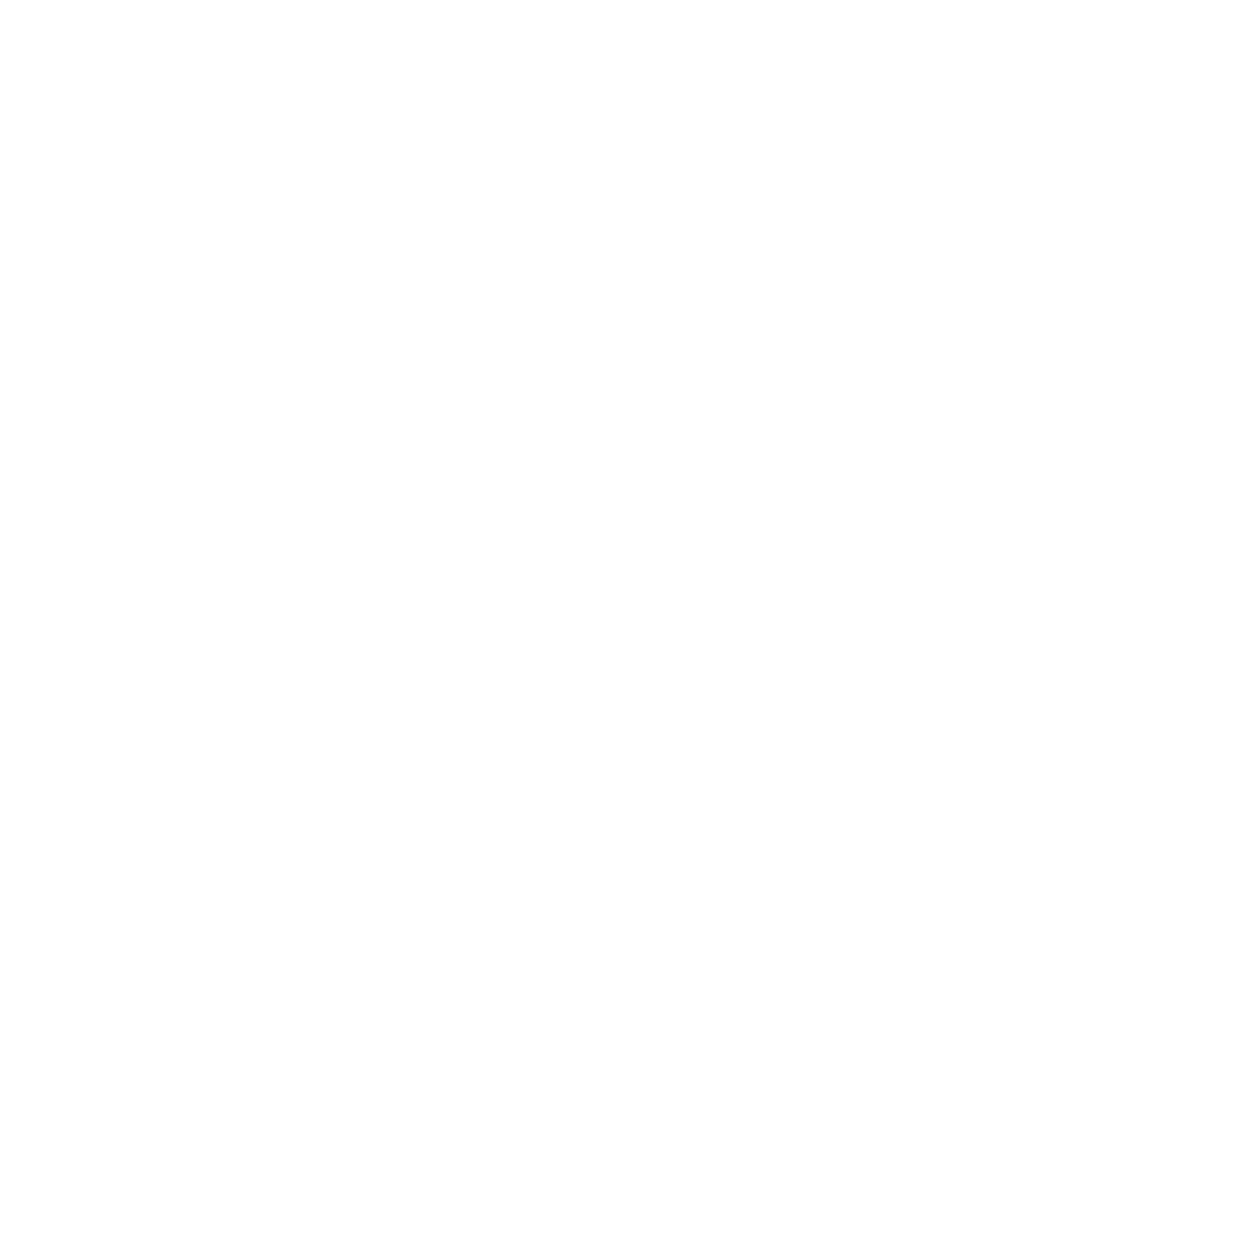

In [45]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plot_clusters_3d(true_groups, iso_df, labels=unique_labels, title='Isomap 3 components', colormap='tab10', xmax=35)


In [46]:
pca3d = ReducedDimensionsData(df_feats, data_labels, 'PCA', n_dims=3)
pca3d.reduce(False)
pca3d_data = pca3d.get_data_df().to_numpy()


<IPython.core.display.Javascript object>


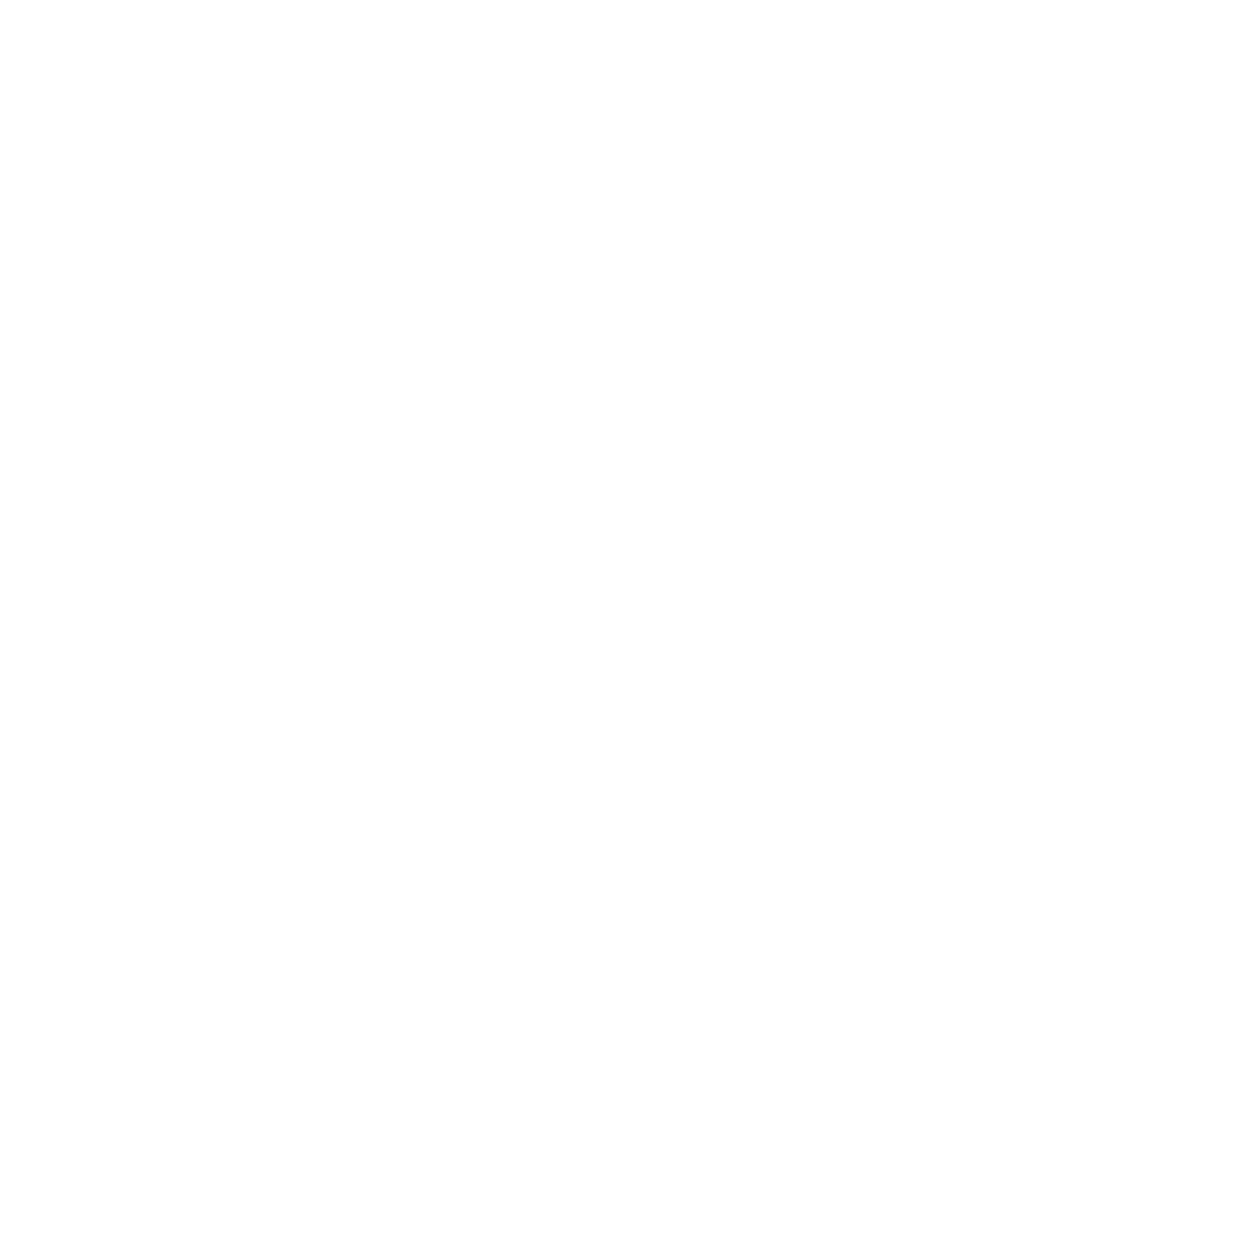

In [47]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plot_clusters_3d(true_groups, pca3d_data, labels=unique_labels, title='PCA 3 components', colormap='tab10', xmax=35)

### Clear visualization depends on randomly selected data
Note that the resulting projection of the data on 3 dimensions will be very different depending on the rows randomly selected at the very beginning of the preprocessing. The visual result is sometimes very clear and allows to see some patterns in the grouping of the categories that are more easily differentiable, but sometimes the projection doesn't result in a visually understandable representation.

Below an example from Isomap and another from PCA are shown, in which the patterns where clear.

From several tries, one could see that Scooter, Custom andTouring categories are often clearly identifiable as forming distinguishable patters, so those are some categories that can be expected to be easily predictable. The Sport and Naked categories show a relevant overlap in the 3D space, so it is possible that the classification algorithms will mistake these bikes, mixing them together. The Allround category looks like it will be a difficult category to characterize, since its
samples are scattered all over the 3-dimensional projections (which makes sense according to its name).

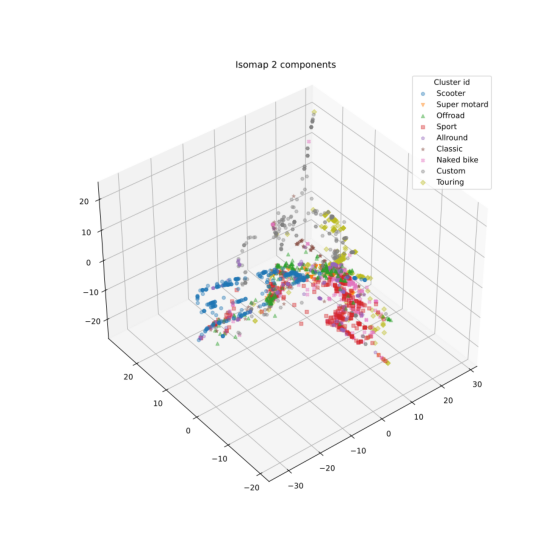

In [48]:
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

with Image.open(os.path.join(RESULTS_PATH,"isomap3d_2.png")) as im:
    #im.show()
    plt.figure(figsize = (10,10))
    plt.axis('off')
    plt.imshow(im)

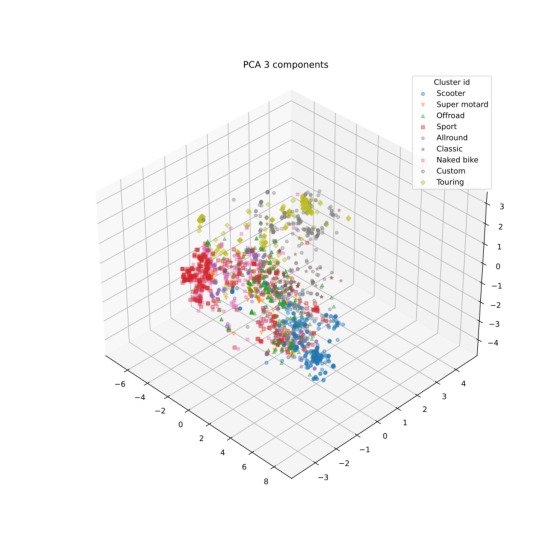

In [49]:
with Image.open(os.path.join(RESULTS_PATH,"pca3d_2.png")) as im:
    #im.show()
    plt.figure(figsize = (10,10))
    plt.axis('off')
    plt.imshow(im)

# 2. Unsupervised classification: K-Means
As an experiment, it could be interesting to see whether the K-Means algorithm is able to form clusters that accurately group bikes of the same category. The samples belong to 9 categories, so we need to ask K-Means to produce 9 clusters.

We can plot the resulting clusters on a 2D or 3D projection and compare them to the plot with true categories.

E:\Anaconda\envs\uoc\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


(<Figure size 720x720 with 1 Axes>, <Axes3DSubplot:>)

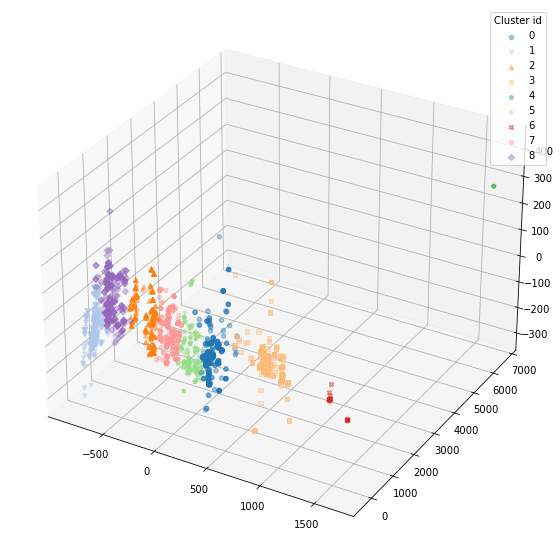

In [50]:
kmeans = apply_KMeans(df_feats, n_clusters=9)
kmeans_assigned = kmeans_assignments(kmeans, df_feats, data_labels)

pca = PCA(n_components=3)
pca.fit(df_feats)
x_feats = pca.transform(df_feats)
plot_clusters_3d(kmeans_assigned, x_feats)

(<Figure size 720x720 with 1 Axes>, <Axes3DSubplot:>)

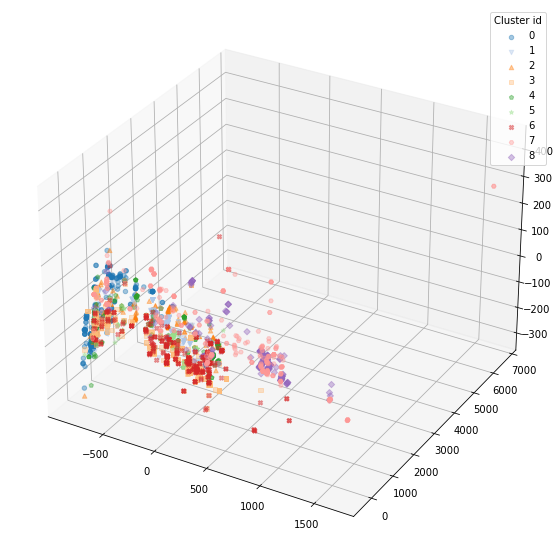

In [51]:
plot_clusters_3d(true_groups, pca3d_data)

The clusters formed by K-Means has clearly nothing to do with the original categories. This is not a suitable method to capture the common treats of each bike category and classify them.

# 3. Supervised classification
Now we will explore different supervised machine learning models for classification. Hopefully, some of those will be able to fit to the underlying relationship of feature values that characterizes a bike of a particular category.

The first step will be to split the data set in a train set and a test set, using the [scikit-learn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. We will reserve 20% of the data for testing.

I also make sure that the data subsets are of numpy.ndarray type, since I encountered some sporadic errors when using DataFrames.

In [53]:
trainX, testX, trainY, testY = train_test_split(df_feats, data_labels, test_size = 0.2)
trainXarr, testXarr, trainYarr, testYarr = split_data_to_arrays(trainX, testX, trainY, testY)
# This is done here for ilustration purposes only. The splitting is actually implemented in the functions defined to tune the
# different ML methods

### Procedure
For each of the machine learning techniques used, there are some hyperparameters to tune. In order to automate the process of model selection, I defined a series of functions in the module apply_ml.py, that return the best model found and some metrics of my interest. I chose the Accuracy as the metric to pick the best model. Even though the hyperparameter tuning is hidden within those functions, I will briefly explain in each case what they are doing.

The accuracy metric of the final model is obtained through [cross validation (scikit learn implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), in order to obtain a more reliable value that does not depend on one particular random split of the data.

### No theory
I also want to state that I am not going to explain the theoretical details behind each method used. This is a practical application notebook and is not intended to be a lecture on machine learning theory (as you can see I haven't explained PCA, Isomap and K-Means either).

### Hyperparameter tuning commented out
The hyperparameter tuning is highly time-consuming and needs a lot of computing resources, so in this notebook I've commented those functions out and then trained a model with the best combination of hyperparameters I obtained from tuning.

In [54]:
# Import useful sklearn functions
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 3.1. Decission Tree Classifier
The hyperparameters we will tune in the [Decision Tree (scikit-learn implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) are the decision criterion and the pruning coefficient $\alpha$.

We will experiment with the criterions: Gini, Entropy, and Log-loss.

The pruning technique allows to reduce the complexity of the tree (reducing overfitting), while retaining performance. Using the method cost_complexity_pruning_path() of the DecisionTreeClassifier class, we obtain a list of effective $\alpha$ values, and so it is not necessary to try thousands of arbitrary values.

In [55]:
# Using the user defined function tune_DecisionTree that outputs the best classifier obtained, its accuracy,
# the report produced by the scikit-learn classification_report() function and the confusion matrix, obtained
# using the scikit-learn confusion_matrix() function.

#tree_clf, tree_acc, report, conf_mat = tune_DecisionTree(df_feats, data_labels)

In [56]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', ccp_alpha=0.001050117).fit(trainXarr, trainYarr)
cv = ShuffleSplit(n_splits=5, test_size=0.2)
print('Cross validation accuracy: ', cross_val_score(tree_clf, trainXarr, trainYarr, cv=cv, scoring='accuracy').mean())
print('Test accuracy: ', accuracy_score(tree_clf.predict(testXarr), testYarr))

Cross validation accuracy:  0.7983870967741936
Test accuracy:  0.8043010752688172


## 3.2. Random Forest Classifier
We should ususally expect a better performance by a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) than by a Decision Tree, since the Random Forest takes advantage of an ensemble of several Decision Trees.

In this case, the only hyperparameter we will tune is the size of the classifier (number of decision trees). The individual trees will use the Gini decision criterion an the same pruning $\alpha$ obtained before. The size of the classifier is obtained by trying increasingly more trees, until the Out Of Bag metric (see oob_score argument and attribute of the RandomForestClassifier in sklearn) estabilizes, indicating that the model is not improving anymore by adding more trees.

In [57]:
#forest_clf, forest_acc, report, conf_mat = tune_RandomForest(df_feats, data_labels, test_size=0.2, best_alpha=0.001050117) 

In [58]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=35, bootstrap=True,
                                        ccp_alpha=0.001050117, oob_score=True,
                                        random_state=0)
rf_clf.fit(trainXarr, trainYarr)
cv = ShuffleSplit(n_splits=5, test_size=0.2)
print('Cross validation accuracy: ', cross_val_score(rf_clf, trainXarr, trainYarr, cv=cv, scoring='accuracy').mean())
print('Test accuracy: ', accuracy_score(rf_clf.predict(testXarr), testYarr))

Cross validation accuracy:  0.8516129032258064
Test accuracy:  0.8516129032258064


## 3.3. Neural Network Classifier
First of all, note that the Neural Network will not fit the data correctly if we leave the binary features unscaled. For that reason, we use the StandardScaler on the data set, to ensure all features are scaled.

Using the [scikit-learn MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), there are a lot of influential hyperparameters we can easily tune. Here are the ones I have used for my tuning:


In [59]:
parameter_space = {
        'hidden_layer_sizes': [(50,25,10), (45,90,20), (90,10),(45,90,90,45)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.01, 0.05],
        'learning_rate': ['constant','adaptive'],
        'early_stopping': [True, False]
        }

The search of the best hyperparameter combination is supported by [scikit-learn's GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). I have used it to choose the best model according to the accuracy of a 5-fold cross validation:

search = GridSearchCV(MLPClassifier(max_iter=2000), parameter_space, n_jobs=-1, cv=5, scoring='accuracy')

In [60]:
#mlp_clf, mlp_acc_cv, report, conf_mat, params = tune_MLP(df_feats, data_labels, test_size=0.2)

In [61]:
from sklearn.neural_network import MLPClassifier
# Standardize data for MLP
mlp_data = StandardScaler().fit(df_feats).transform(df_feats)
trainX, testX, trainY, testY = train_test_split(mlp_data, data_labels, test_size = 0.2)
trainXarr_mlp, testXarr_mlp, trainYarr_mlp, testYarr_mlp = split_data_to_arrays(trainX, testX, trainY, testY)


mlp_clf = MLPClassifier(activation='tanh', alpha=0.05, early_stopping=False,
                        hidden_layer_sizes=(90,10), learning_rate='adaptive',
                        solver='adam', max_iter=3000)
mlp_clf.fit(trainXarr_mlp, trainYarr_mlp)

cv = ShuffleSplit(n_splits=5, test_size=0.2)
print('Cross validation accuracy: ', cross_val_score(mlp_clf, trainXarr_mlp, trainYarr_mlp, cv=cv, scoring='accuracy').mean())
print('Test accuracy: ', accuracy_score(mlp_clf.predict(testXarr_mlp), testYarr_mlp))

Cross validation accuracy:  0.8209677419354838
Test accuracy:  0.8473118279569892


## 3.4. Linear Support Vector Classification
In the case of this Support Vector Machine type classificator, there are also several hyperparameters to be tuned. Once more, we use grid search to obtain the better combination of the hyperparameter values we decide to try. In my case, I've tried the following (find more about this in the [scikit learn LinearSVC implementation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)):

In [62]:
parameter_space = {
        'penalty':['l1','l2'],
        'C': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4],
        'multi_class':['ovr', 'crammer_singer'],
        }

With this classifier we are limited to using only a linear kernel. The problem is that, if we wanted to used more complex kernels, the C-SVC ([scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)) method is highly time consuming, a fact that is noticeable when working on our data set. As explained in the scikit-learn documentation: "The fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples."

Again in this case, it is necessary to standardize the binary features for the Linear SVC algorithm to work. For this reason, we will reuse the arrays standardize before for MLP.

In [63]:
#lsvc_clf, lsvc_acc, report, conf_mat, params = tune_LSVM(df_feats, data_labels, test_size=0.2)

from sklearn.svm import LinearSVC
lsvc_clf = LinearSVC(C=1, multi_class='crammer_singer', penalty='l1', max_iter=50000).fit(trainXarr_mlp, trainYarr_mlp)


cv = ShuffleSplit(n_splits=5, test_size=0.2)
print('Cross validation accuracy: ', cross_val_score(lsvc_clf, trainXarr_mlp, trainYarr_mlp, cv=cv, scoring='accuracy').mean())
print('Test accuracy: ', accuracy_score(lsvc_clf.predict(testXarr_mlp), testYarr_mlp))

E:\Anaconda\envs\uoc\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Cross validation accuracy:  0.731720430107527
Test accuracy:  0.6795698924731183


E:\Anaconda\envs\uoc\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## 3.5. K-Nearest Neighbors Classifier
Using the [scikit-learn KNeighborsClassifier class](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), we perform grid search to find the better combination of the following parameters:

In [64]:
parameter_space = {
        'n_neighbors': [3,4,5,6],
        'algorithm': ['ball_tree', 'kd_tree'],
        'p':[1,2]
        }

In [65]:
#knn_clf, knn_acc, report, conf_mat, params = tune_KNN(df_feats, data_labels)

from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', p=1, n_jobs=-1).fit(trainXarr, trainYarr)

cv = ShuffleSplit(n_splits=5, test_size=0.2)
print('Cross validation accuracy: ', cross_val_score(knn_clf, trainXarr, trainYarr, cv=cv, scoring='accuracy').mean())
print('Test accuracy: ', accuracy_score(knn_clf.predict(testXarr), testYarr))

Cross validation accuracy:  0.7989247311827956
Test accuracy:  0.8021505376344086


In [66]:
models = {'Decision Tree':[tree_clf, (testXarr, testYarr)], 'Random Forest':[rf_clf, (testXarr, testYarr)],
          'Neural Network':[mlp_clf, (testXarr_mlp, testYarr_mlp)], 'LinearSVC':[lsvc_clf, (testXarr_mlp, testYarr_mlp)],
          'KNN':[knn_clf, (testXarr, testYarr)]}
results = {}
for name, model in models.items():
    results[name] = accuracy_score(model[0].predict(model[1][0]), model[1][1])
results_series = pd.Series(results)
results_series

Decision Tree     0.804301
Random Forest     0.851613
Neural Network    0.847312
LinearSVC         0.679570
KNN               0.802151
dtype: float64

(0.0, 1.0)

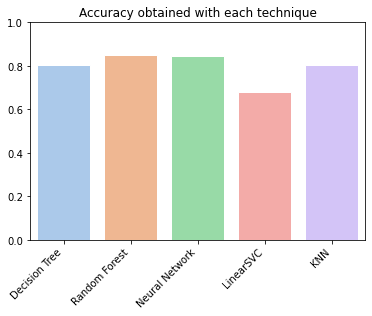

In [67]:
fig, ax = bar_plot_series(results_series, title="Accuracy obtained with each technique", palette="pastel")
ax.set_ylim(top=1)

### 3.6. Evaluation

The better classification technique for this problem is Random Forest followed by Neural Network. This could have been expected, because those two are known to be able to fit very complex patters, which is necessary for this data defined by 43 features.

Nonetheless, it is remarkable how well the Decision Tree and KNN models perform in terms of accuracy, given that they work based on quite simple rules.

#### Confusion matrix and metrics
Using our best model, the Random Forest we tuned and trained, we can obtain some insights on the data by looking at the confusion matrix and the nice classification report from scikit learn.

In the confusion matrix below, we can confirm the suspicions about Sport and Naked bikes being difficult to tell appart based only upon the technical data we have. The showed huge overlap in the 3D projections of the data, and the confusion matrix shows that 14 Sports bikes were classified as Naked, whereas 6 Naked bikes were classified as Sport. Those  are the two highest False classification counts of any class in the test set (matched by Allround misclassified 6 times as Naked). This problem is also reflected by the metrics in the report displayed further below, where the Sport category is the one with the lowest scores, achieving under 0.7 f1-score.

We were also expecting that the Scooter, Custom and Touring categories would be easier to be characterized by the machine learning algorithms, which is confirmed. The Scooter category obtained an outstanding 0.964 f1-score value. The Random Forest Classifier predicted Custom and Touring with an f1-score of 0.927 and 0.931, respectively. Finally, it also performed really well when classifying Classic bikes, which was not obvious from the 3D visualizations.

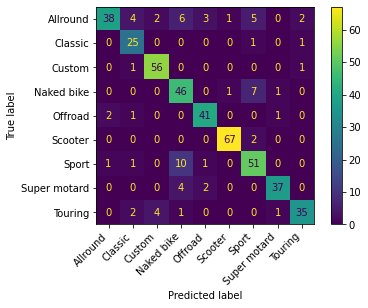

In [68]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(testYarr, rf_clf.predict(testXarr), labels=rf_clf.classes_)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf_clf.classes_)

disp.plot(ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')

In [69]:
report = classification_report(testYarr, rf_clf.predict(testXarr), output_dict=True)
df_report = pd.DataFrame(report).T

In [70]:
df_report

,precision,recall,f1-score,support
Allround,0.926829,0.622951,0.745098,61.000000
Classic,0.735294,0.925926,0.819672,27.000000
Custom,0.903226,0.965517,0.933333,58.000000
Naked bike,0.686567,0.836364,0.754098,55.000000
Offroad,0.872340,0.911111,0.891304,45.000000
Scooter,0.971014,0.971014,0.971014,69.000000
Sport,0.772727,0.796875,0.784615,64.000000
Super motard,0.925000,0.860465,0.891566,43.000000
Touring,0.897436,0.813953,0.853659,43.000000
accuracy,0.851613,0.851613,0.851613,0.851613


# 4. Dimensionality reduction
We have already seen that a data set describing around 23000 motorcycles based on 43 features (obtained from 26 original columns) can be used to train classification models that achieve an accuracy up to 0.847. That is proof that technical specifications are descriptive of the category of a motorcycle. Now we could ask ourselves: **would it be possible to predict motorcycle categories having those bikes described by a lower amount of features?**

To find that out, we can try to use again **PCA** to **reduce the dimensions** of the data. We will also try to leverage the **feature selection** capabilities of ***lasso regression** and train our models on the same examples, represented by only some reduced selection of features.

We could try those approaches on all the different machine learning techniques presented before, and I have actually coded all the necessary functions in the apply_ml.py module, but here I will just present the Decision Tree and Random Forest techniques.

## 4.1. PCA
Using Principal Components analysis, we can find the principal components on which to project the data while retaining the maximum variance. In order to select the number of principal components that will be used to represent the data, we can either make an arbitrary decision or establish a minimum variance required to consider that enough information about the data set is retained. We will take the second approach, with a minimum requirement to retain 90% of the data variance.

In [71]:
tree_pca_clf, tree_pca_acc, report, conf_mat = DecisionTree_on_pca_features(df_feats, data_labels, pca_explain=0.9)
best_alpha_pca = tree_pca_clf.ccp_alpha

90.37 percent of data explained by 19 components


In [72]:
report['accuracy']

0.7806451612903226

In [73]:
forest_pca_clf, forest_pca_acc, report, conf_mat = RandomForest_on_pca_features(df_feats, data_labels, pca_explain=0.9)


90.37 percent of data explained by 19 components


E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

In [74]:
report['accuracy']

0.8258064516129032

## 4.2. Lasso feature selection
When performing regression using the lasso method, it tends to reduce to zero the influence of the parameters weighting the least significant features. That is an useful characteristic to find out which features are more influential at defining the different categories in the data set.

*Note: in the particular case of our data set, lasso doesn't always end up discarding features. For that reason, the function I've written will run lasso regression in a loop until one run does discard several features.

In [75]:
tree_lasso_clf, tree_lasso_acc, report, conf_mat = DecisionTree_on_lasso_features(df_feats, data_labels)
best_alpha_lasso = tree_lasso_clf.ccp_alpha

Lasso found 10 relevant features:
['Power (hp)' 'Bore (mm)' 'Stroke (mm)' 'Fuel capacity (lts)'
 'Dry weight (kg)' 'Wheelbase (mm)' 'Transmission type_Belt'
 'Rear tire_diameter' 'Front tire_height' 'fronttyre_speed']


In [76]:
print('Decision Tree Cross validation accuracy: ', tree_lasso_acc)
print('Decision Tree Test accuracy: ', report['accuracy'])

Decision Tree Cross validation accuracy:  0.8134408602150538
Decision Tree Test accuracy:  0.8473118279569892


In [77]:
forest_lasso_clf, forest_lasso_acc_, report, conf_mat = RandomForest_on_lasso_features(df_feats, data_labels)


Lasso found 10 relevant features:
['Displacement (ccm)' 'Bore (mm)' 'Fuel capacity (lts)' 'Dry weight (kg)'
 'Wheelbase (mm)' 'Transmission type_Belt' 'Rear tire_diameter'
 'Front tire_height' 'reartyre_speed' 'fronttyre_speed']


E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
E:\Anaconda\envs\uoc\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

In [78]:
print('Random Forest Cross validation accuracy: ', forest_lasso_acc_)
print('Random Forest Test accuracy: ', report['accuracy'])

Random Forest Cross validation accuracy:  0.8333333333333334
Random Forest Test accuracy:  0.8602150537634409


## 4.3. Evaluation
These results ar very interesting  and tell a lot about the capabilities of these algorithms to find patterns that characterize the data.

Using the 19 first principal components of the data, both models kept a test accuracy above 80%, although in both cases showing a slight reduction with respect to their score on the full dataset. However, this is still a remarkable result, since the models were trained on only 19 features, which means less than half the amount of information they had before! This also goes to show the importance of the PCA method projecting the data on the highest-variance directions, because the data samples are still distinctively described by these new features, even though they are completely detached of any real-world meaning that the original features had.

The case of the features selected using lasso regression is even more noteworthy. The Random Forest slightly increased its accuracy, with 0.862 vs 0.856 obtained using the complete data!. On the other hand, the Decision Tree resulting model was also an even better classifier than the one trained on the original data, with a test accuracy of 0.83 vs 0.81 on the whole data! As we see in the output of the code cells above, these results were obtained **using only 12 of the original features on the Decision Tree, and 9 of the features on the Random Forest. That means that the motorcycle categories can be identified with much less features than we had available!**